In [ ]:
!pip install sentence-transformers

In [2]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import gensim
import wordcloud
import textblob
import spacy
import string
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import word2vec
nltk.download('stopwords')
from nltk.corpus import stopwords
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import joblib

# Functions

In [ ]:
def plot_word_number_histogram(text: str) -> None:
    """
    Function to display number of words
    :param text: input text
    """
    text.str.split().\
        map(lambda x: len(x)).\
        hist()


def plot_word_length_histogram(text: str) -> None:
    """
    Function for display word lenght
    :param text: input text
    """
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()


def plot_top_stopwords_barchart(text: str) -> list:
    """
    Function for clean and display stop words
    :param text: input text
    """
    stop=set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    dic = defaultdict(int)

    for word in corpus:
        if word in stop:
            dic[word] += 1
            
    top = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:10] 
    x,y = zip(*top)
    plt.bar(x,y)

    return corpus


def plot_top_non_stopwords_barchart(text: str) -> None:
    """
    Function for display non stop words
    :param text: input text
    """
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y, y=x)


def plot_top_ngrams_barchart(text: str, n=2) -> None:
    """
    Function for display top of ngrams
    :param text: input text
    :param n: default = 2, size of ngram
    """
    stop = set(stopwords.words('english'))

    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None) -> list:
        """
        Function for get top ngram
        :param corpus: list of words
        :param n: size of ngrams
        """
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)


def clear_string(text: str) -> str:
  """
  Function for cleaning text
  :param text: input text
  """
  text = ''.join([word for word in text if word not in string.punctuation])
  text = text.lower()
  text = ' '.join([word for word in text.split() if word not in stop])
  return text


def cosine_to_pred(cosine_sim: float, threshold: float) -> int:
    """
    Finction for convert cosine similarity to label
    :param cosine_sim: cosine distance
    :param threshold: threshold for separate 0 and 1  classes
    """
    if cosine_sim < threshold:
        label = 0
    else:
        label = 1
        
    return label

# Загрузка данных

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv(
    '/content/drive/MyDrive/Matching_string_project/Data/train.csv', index_col='pair_id')

In [4]:
df[:5]

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [5]:
df.shape

(497819, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


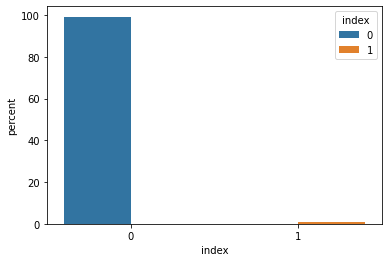

In [ ]:
# check balance classes
target = df.is_duplicate.value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.barplot(x='index', y='percent', data=target, hue='index');

# Анализ текстовой статистики

In [ ]:
# сформируем стоп слова
stop = set(stopwords.words('english'))

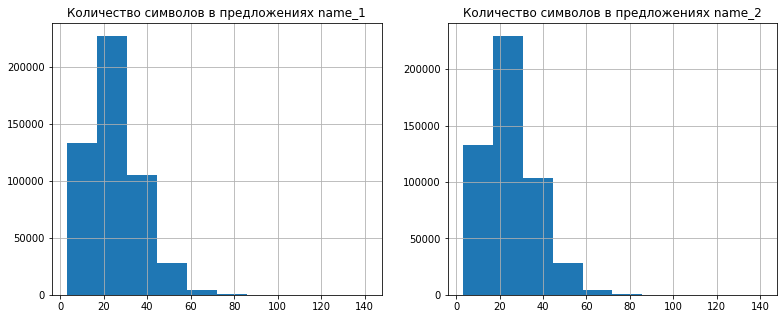

In [ ]:
plt.figure(figsize=(13, 5))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  df[col].str.len().hist()
  plt.title(f'Количество символов в предложениях {col}')

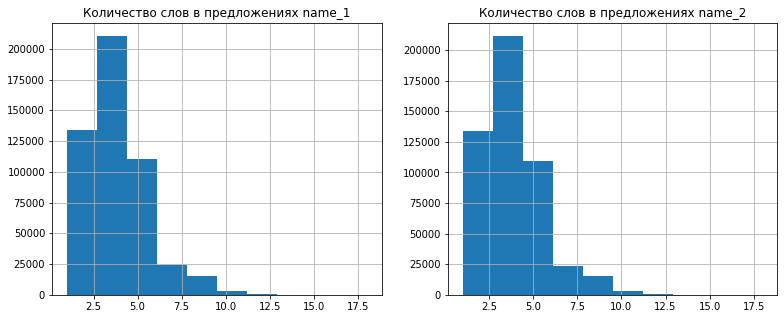

In [ ]:
plt.figure(figsize=(13, 5))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_word_number_histogram(df[col])
  plt.title(f'Количество слов в предложениях {col}')

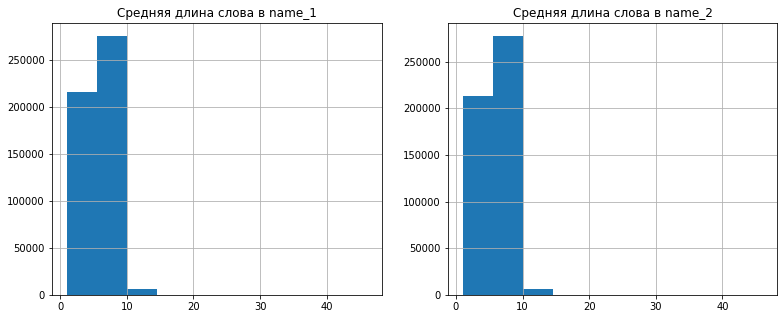

In [ ]:
plt.figure(figsize=(13, 5))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_word_length_histogram(df[col])
  plt.title(f'Средняя длина слова в {col}')

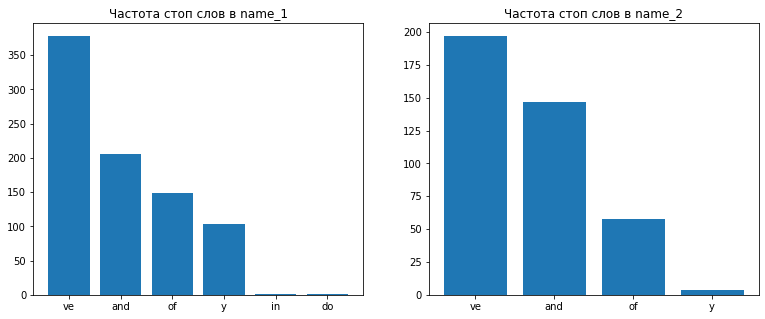

In [ ]:
plt.figure(figsize=(13, 5))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_top_stopwords_barchart(df[col])
  plt.title(f'Частота стоп слов в {col}')

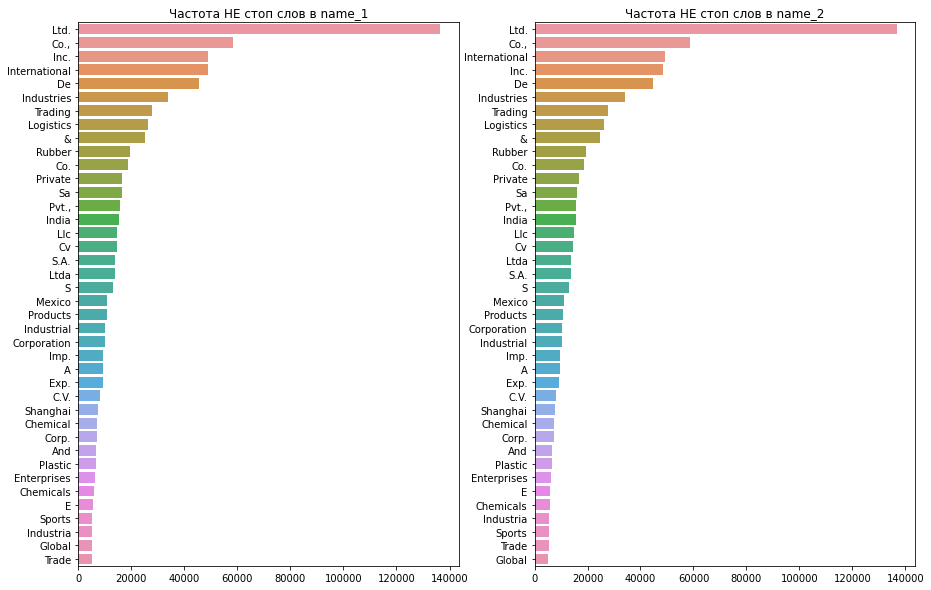

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_top_non_stopwords_barchart(df[col])
  plt.title(f'Частота НЕ стоп слов в {col}')

# Исследование Ngram

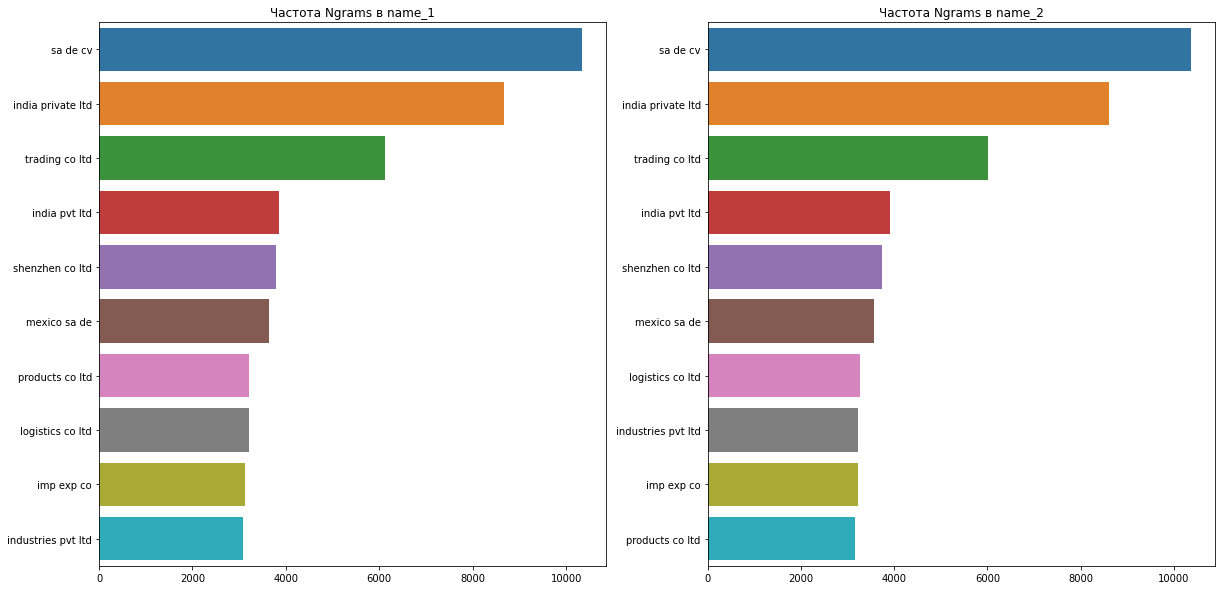

In [ ]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(df.columns[:2]):
  plt.subplot(1, 2, i+1)
  plot_top_ngrams_barchart(df[col], 3)
  plt.title(f'Частота Ngrams в {col}')

# Очистка данных

In [9]:
df

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0
...,...,...,...
497815,BIT-MAT PRODUCTS,The Goodyear Tire and Rubber Company,0
497816,"Bnd Trading Co., Ltd.",Zhong Shan Yue Liang Economy& Trade Imp. & Exp...,0
497817,"Xeikon Industrial Co., Ltd. Of Dongguan City","Yi Cheng Trading Co., Ltd. Of Dongguan City",0


In [6]:
df['name_1'] = df.apply(lambda x: clear_string(x['name_1']), axis=1)

In [7]:
df['name_2'] = df.apply(lambda x: clear_string(x['name_2']), axis=1)

In [ ]:
df.to_csv('/content/drive/MyDrive/Matching_string_project/Data/cleaned.csv', index=False)

# Sentense Bert

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [50]:
corpus1 = df['name_1'].to_list()
corpus2 = df['name_2'].to_list()

In [26]:
model = SentenceTransformer('all-mpnet-base-v2', device='cuda')

In [62]:
embeddings1 = model.encode(corpus1, convert_to_tensor=True)
embeddings2 = model.encode(corpus2, convert_to_tensor=True)

In [63]:
cosine_sim=[]

for i in range(len(embeddings1)):
    score=util.cos_sim(embeddings1[i],embeddings2[i])
    cosine_sim.append(score[0].item())

In [64]:
df['cosine_sim']=cosine_sim

In [65]:
df['pred'] = df['cosine_sim'].apply(lambda x: cosine_to_pred(x, 0.8))

In [66]:
print('F1_score =', f1_score(df['is_duplicate'], df['pred']))

F1_score = 0.1603191186247507


In [67]:
print('Rocauc score =', roc_auc_score(df['is_duplicate'], df['cosine_sim']))

Rocauc score = 0.8461735925234948


In [68]:
print('Precision score =', precision_score(df['is_duplicate'], df['pred']))

Precision score = 0.12283510406054432


In [69]:
print('Recall score =', recall_score(df['is_duplicate'], df['pred']))

Recall score = 0.23072717331875342


# Bert Training

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Matching_string_project/Data/cleaned.csv')

In [11]:
df_train = df.copy()

In [12]:
df_train.is_duplicate = df_train.is_duplicate.astype('float32')
df_train['name_1'] = df_train['name_1'].astype(str)
df_train['name_2'] = df_train['name_2'].astype(str)

In [13]:
df_train[:2]

,name_1,name_2,is_duplicate
0,iko industries ltd,enormous industrial trade pvt ltd,0.0
1,apcotex industries ltd,technocraft industries india ltd,0.0


In [14]:
train, test  = train_test_split(df_train, stratify=df_train.is_duplicate, test_size=0.2, random_state=10)

In [15]:
# создаем примеры: предложение 1, предложение 2, метка класса
samples = []
for row in range(train.shape[0]):
  label = train.iloc[row][2]
  inp_example = InputExample(texts=[train.iloc[row][0], train.iloc[row][1]], label=label)
  samples.append(inp_example)


In [16]:
train_dataloader = DataLoader(samples, shuffle=True, batch_size=16)

In [17]:
torch.cuda.empty_cache()

#Define the model. Either from scratch of by loading a pre-trained model
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

#Define your train dataset, the dataloader and the train loss

train_loss = losses.CosineSimilarityLoss(model)

#Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/24891 [00:00<?, ?it/s]

In [21]:
joblib.dump(model, '/content/drive/MyDrive/Matching_string_project/Models/sent_bert.joblib')

['/content/drive/MyDrive/Matching_string_project/Models/sent_bert.joblib']

In [ ]:
joblib.load('/content/drive/MyDrive/Matching_string_project/Models/sent_bert.joblib')

In [22]:
corpus1 = test['name_1'].to_list()
corpus2 = test['name_2'].to_list()

In [24]:
# создаем эмбеддинги
embedding1 = model.encode(corpus1, convert_to_tensor=True)
embedding2 = model.encode(corpus2, convert_to_tensor=True)

In [27]:
# создаем список расстояний по каждой паре
cosine_sim=[]

for i in range(len(embedding1)):
    score=util.cos_sim(embedding1[i],embedding2[i])
    cosine_sim.append(score[0].item())

In [28]:
test['cosine_sim']=cosine_sim

In [29]:
# преобразовываем расстояния в классы с порогом 0.8
test['pred'] = test['cosine_sim'].apply(lambda x: cosine_to_pred(x, 0.8))

In [32]:
print('F1_score =', f1_score(test['is_duplicate'], test['pred']))
print('Precision score =', precision_score(test['is_duplicate'], test['pred']))
print('Recall score =', recall_score(test['is_duplicate'], test['pred']))

F1_score = 0.9104046242774566
Precision score = 0.9662576687116564
Recall score = 0.860655737704918
